# Pràctica 1: Regressions lineals


### Base de dades

**https://www.kaggle.com/imnikhilanand/heart-attack-prediction**    GRUP: 9 - GPA204-0930

## Apartat (C): Analitzant Dades

L'objectiu d'aquest primer apartat serà conèixer la base de dades que es té entre mans. S'han d'analitzar els diferents atributs que la composen, entendre'ls i, si no està estipulat, **caldrà fixar quin es l'atribut objectiu a predir de tots els que hi ha a la base de dades**, justificant el per què de la decisió (és útil i representatiu pel problema, per exemple, donat un conjunt de dades sobre persones: edat, gènere, pes, alçada, risc de patir càncer, aquesta última pot ser justificada com la de més interés). També podeu mirar que l'atribut objectiu tingui valors que canvien. Per exemple, no té sentit predir un atribut on el 99% dels valors són 0, i hi ha algun 1.

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import math
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('data.csv')
data = dataset.values

x = data[:, :(data.shape[1]-1)]
y = data[:, (data.shape[1]-1)]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (294, 14)
Dimensionalitat de les entrades X (294, 13)
Dimensionalitat de l'atribut Y (294,)


Algunes bases de dades tenen valors no existents. Numpy els representa amb ``np.nan``. Per a treure'ls, podeu fer: ``dades[np.isnan(dades)] = valor``. Podeu mirar com afecten diferents estratègies d'assignar ``valor``. Per exemple, pot ser 0, la mitja, la mediana, .... També podeu analitzar si hi ha algun atribut perdut (que té molts valors no existents) i valorar si eliminar directament l'atribut.

Hi ha vegades que el fitxer .csv utilitza una coma ',' en comptes d'un punt decimal '.', fent que cada atribut sigui considerat com un ``string``. Per tant, a part d'eliminar les files (mostres) que continguin ``NaN``, cal convertir les ',' a '.' per a poder convertir els valors a ``float``.

A més, utilitzeu la llibreria pandas, i no `np.genfromtxt()` ja que llegeix només valors numèrics, i els NaN els converteix a string. Si esteu empenyats en utilitzar `np.genfromtxt()`, caldrà posar-li com a paràmetre `dtype=object`

In [2]:
#Cambiem els valors '?' per NaN's
dataset.replace('?', np.nan, inplace=True)

print("Valors null abans de fer canvis:")
print(dataset.isnull().sum())

#Guardem les columnes amb més del 40% de valors perduts
cols_with_missing = [col for col in dataset.columns 
                     if dataset[col].isnull().sum()/len(dataset[col]) > 0.4]

#Eliminem les columnes seleccionades anteriorment
dataset.drop(cols_with_missing, axis=1, inplace=True)

dataset = dataset.astype('float64')
    
#Asignem el valor de la mediana a les columnes que continguin valors NaN restants
for col in dataset:
    dataset[f'{col}'].replace(np.nan, dataset[f'{col}'].median(), inplace=True)

print("Valors null després de fer canvis:")
print(dataset.isnull().sum())

Valors null abans de fer canvis:
age             0
sex             0
cp              0
trestbps        1
chol           23
fbs             8
restecg         1
thalach         1
exang           1
oldpeak         0
slope         190
ca            291
thal          266
num             0
dtype: int64
Valors null després de fer canvis:
age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
num           0
dtype: int64


In [3]:
print("Per visualitzar les primeres 5 mostres de la BBDD:")
dataset.head() 

Per visualitzar les primeres 5 mostres de la BBDD:


age   sex    cp  trestbps    chol   fbs  restecg  thalach  exang  \
0 28.000 1.000 2.000   130.000 132.000 0.000    2.000  185.000  0.000   
1 29.000 1.000 2.000   120.000 243.000 0.000    0.000  160.000  0.000   
2 29.000 1.000 2.000   140.000 243.000 0.000    0.000  170.000  0.000   
3 30.000 0.000 1.000   170.000 237.000 0.000    1.000  170.000  0.000   
4 31.000 0.000 2.000   100.000 219.000 0.000    1.000  150.000  0.000   

   oldpeak  num         
0    0.000       0.000  
1    0.000       0.000  
2    0.000       0.000  
3    0.000       0.000  
4    0.000       0.000

In [4]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


age     sex      cp  trestbps    chol     fbs  restecg  thalach  \
count 294.000 294.000 294.000   294.000 294.000 294.000  294.000  294.000   
mean   47.827   0.724   2.983   132.575 250.235   0.068    0.218  139.133   
std     7.812   0.448   0.965    17.597  64.982   0.252    0.460   23.550   
min    28.000   0.000   1.000    92.000  85.000   0.000    0.000   82.000   
25%    42.000   0.000   2.000   120.000 211.250   0.000    0.000  122.000   
50%    49.000   1.000   3.000   130.000 243.000   0.000    0.000  140.000   
75%    54.000   1.000   4.000   140.000 277.000   0.000    0.000  155.000   
max    66.000   1.000   4.000   200.000 603.000   1.000    2.000  190.000   

        exang  oldpeak  num         
count 294.000  294.000     294.000  
mean    0.303    0.586       0.361  
std     0.460    0.909       0.481  
min     0.000    0.000       0.000  
25%     0.000    0.000       0.000  
50%     0.000    0.000       0.000  
75%     1.000    1.000       1.000  
max     1.000    5.000       1.000

Per veure les relacions de tots els atributs de la BBDD amb el valor a predir:


<IPython.core.display.Javascript object>


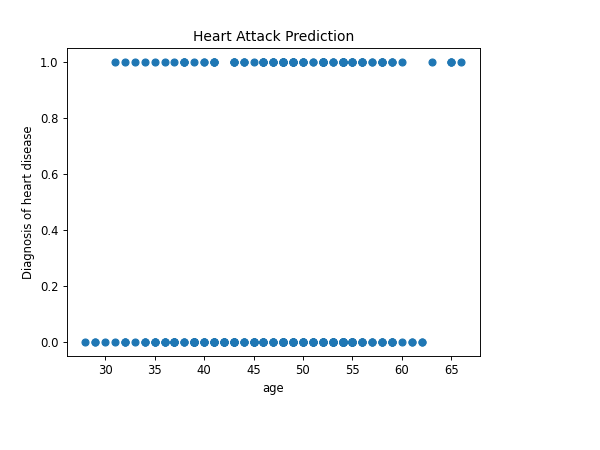

<IPython.core.display.Javascript object>


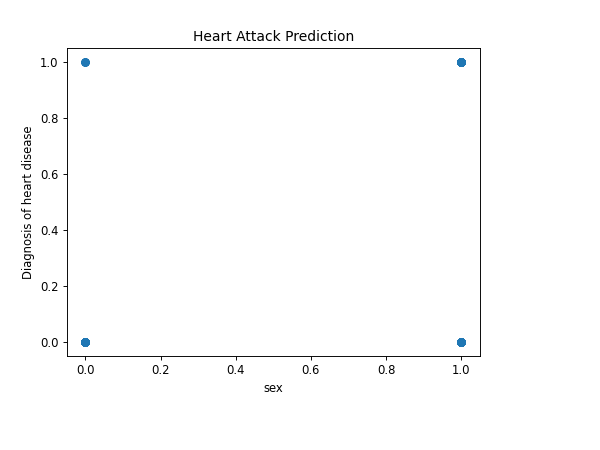

<IPython.core.display.Javascript object>


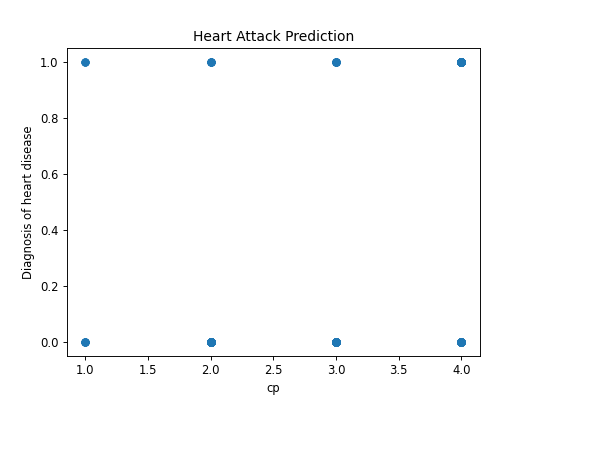

<IPython.core.display.Javascript object>


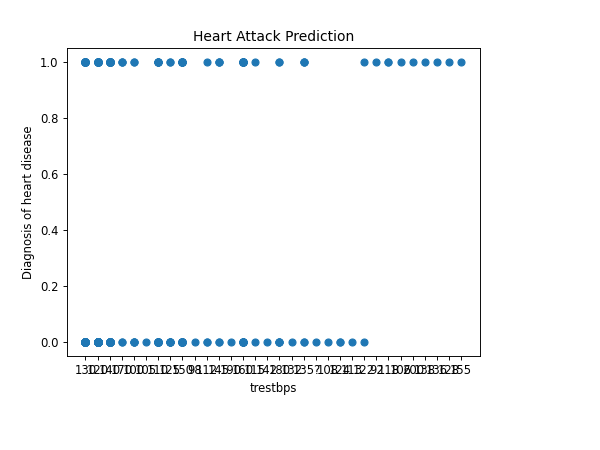

<IPython.core.display.Javascript object>


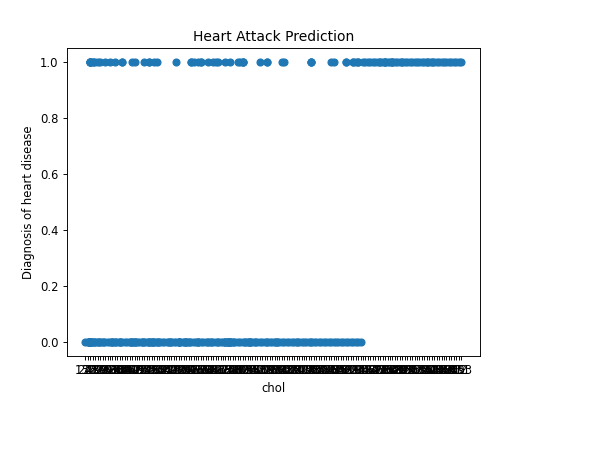

<IPython.core.display.Javascript object>


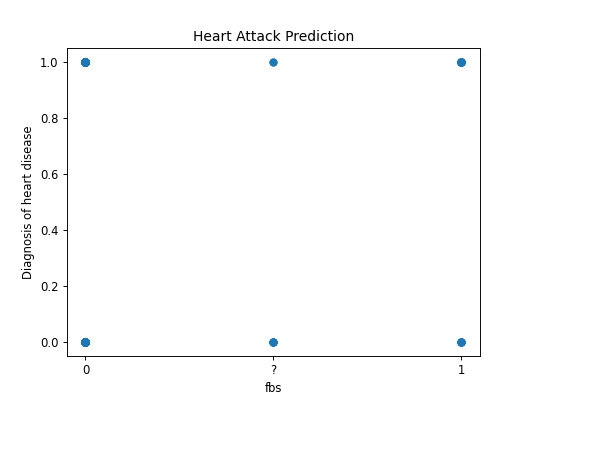

<IPython.core.display.Javascript object>


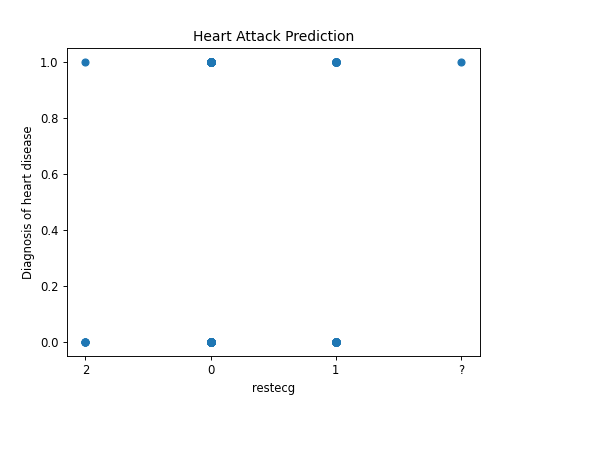

<IPython.core.display.Javascript object>


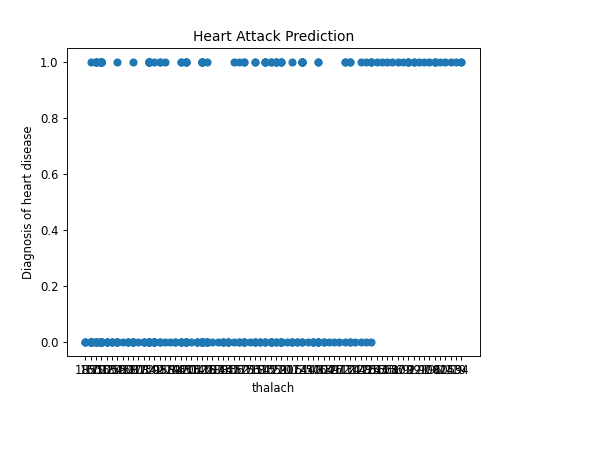

<IPython.core.display.Javascript object>


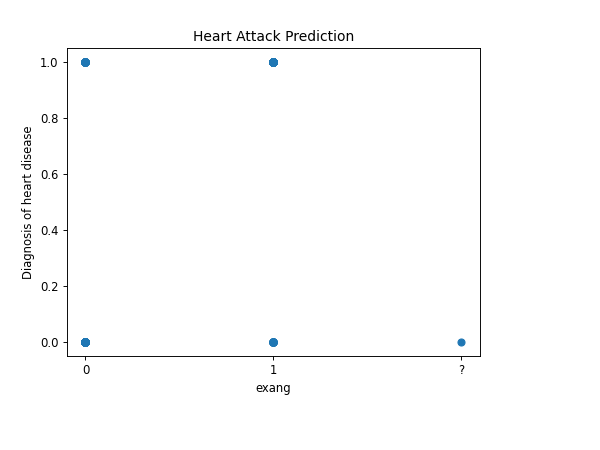

<IPython.core.display.Javascript object>


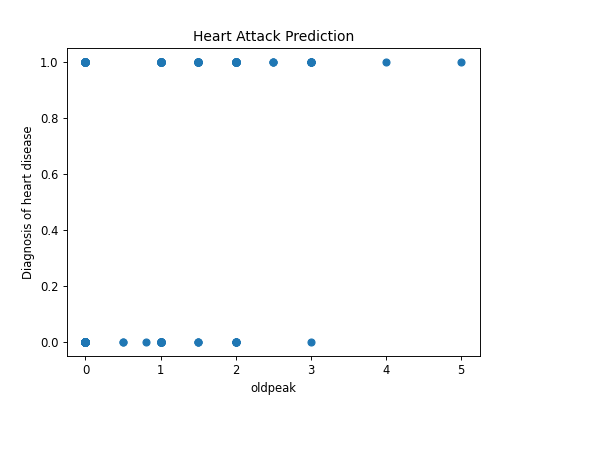

<IPython.core.display.Javascript object>


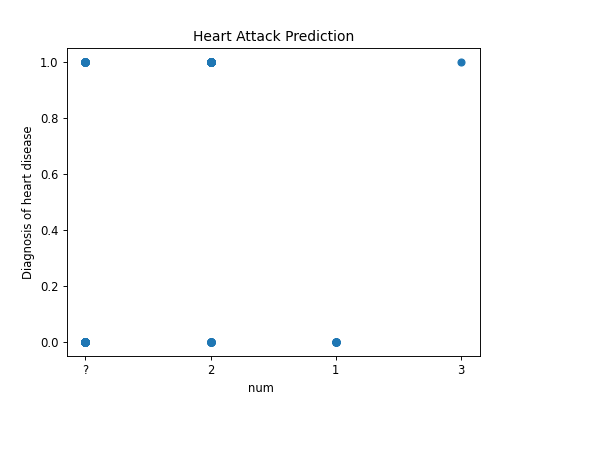

In [5]:
print("Per veure les relacions de tots els atributs de la BBDD amb el valor a predir:")
index = 0
for col in dataset:
    if index < (data.shape[1]-1):
        plt.figure()
        plt.title("Heart Attack Prediction")
        plt.xlabel(f"{col}")
        plt.ylabel("Diagnosis of heart disease")
        ax = plt.scatter(x[:,index],y)
        index = index + 1

Per veure els histogrames de tots els atributs de la BBDD:


<IPython.core.display.Javascript object>


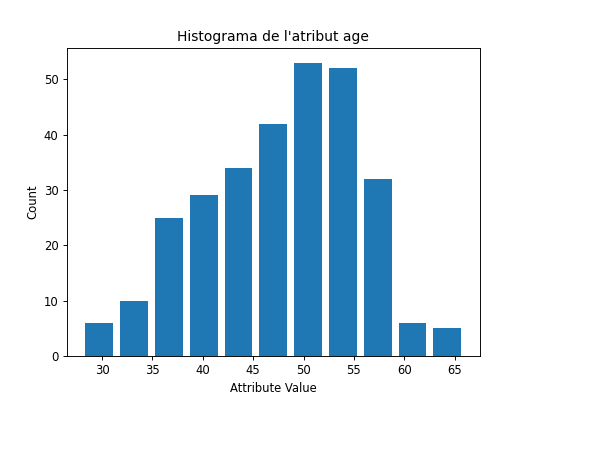

<IPython.core.display.Javascript object>


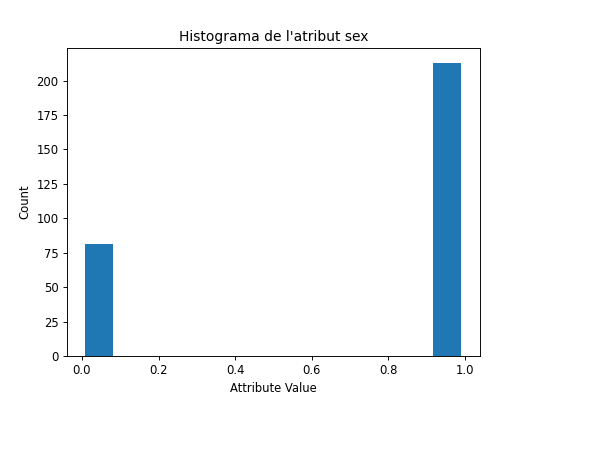

<IPython.core.display.Javascript object>


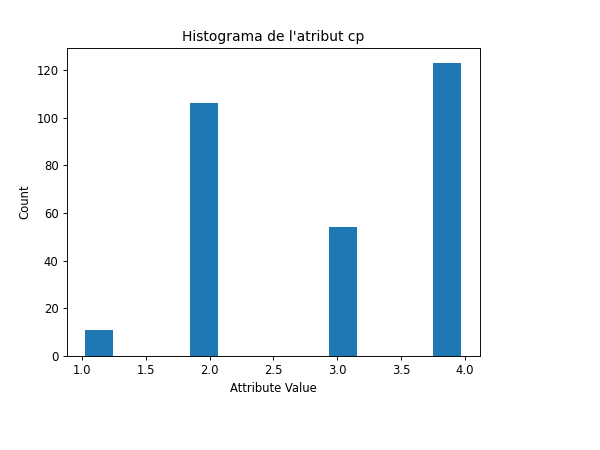

<IPython.core.display.Javascript object>


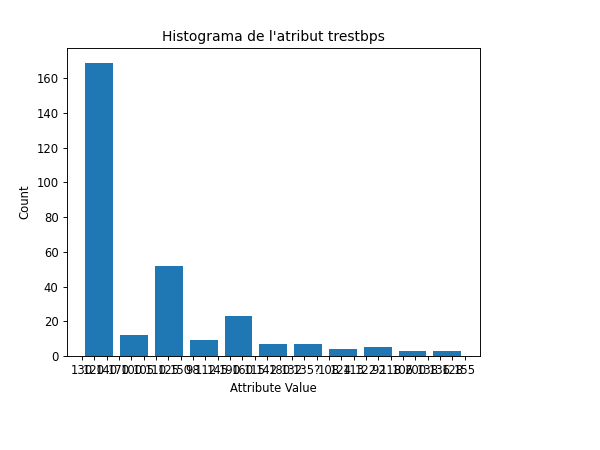

<IPython.core.display.Javascript object>


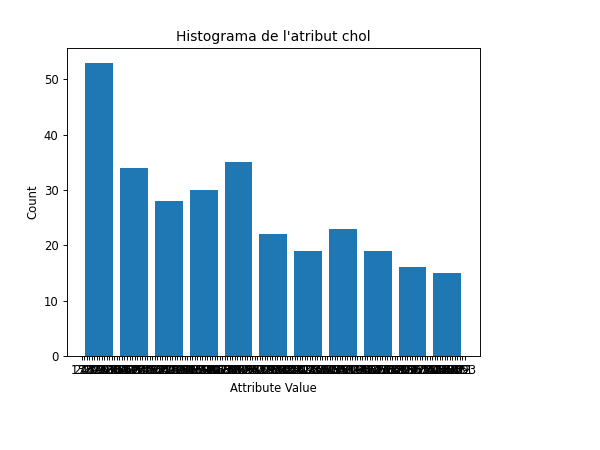

<IPython.core.display.Javascript object>


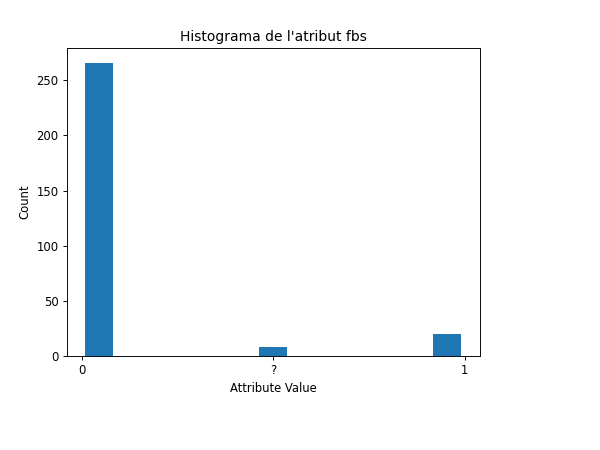

<IPython.core.display.Javascript object>


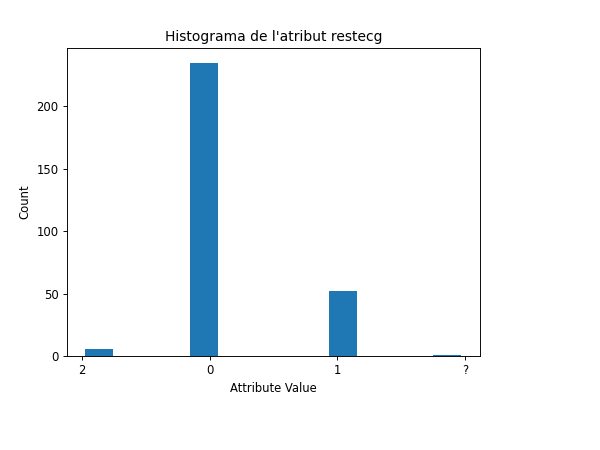

<IPython.core.display.Javascript object>


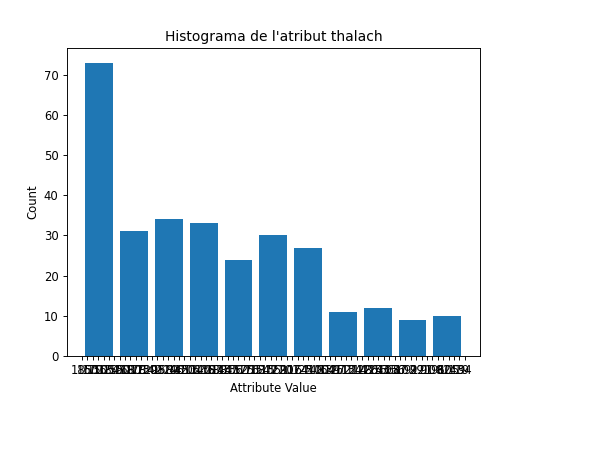

<IPython.core.display.Javascript object>


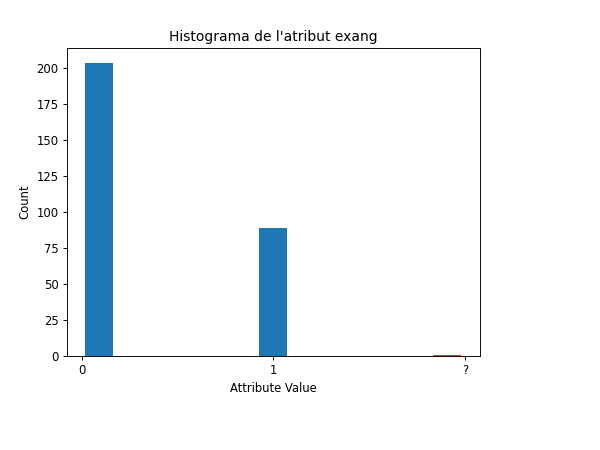

C:\Users\marcs\AppData\Local\Temp\ipykernel_4192\1053446444.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


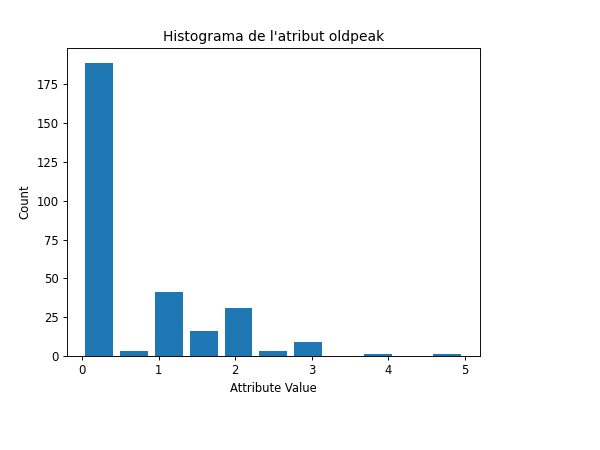

<IPython.core.display.Javascript object>


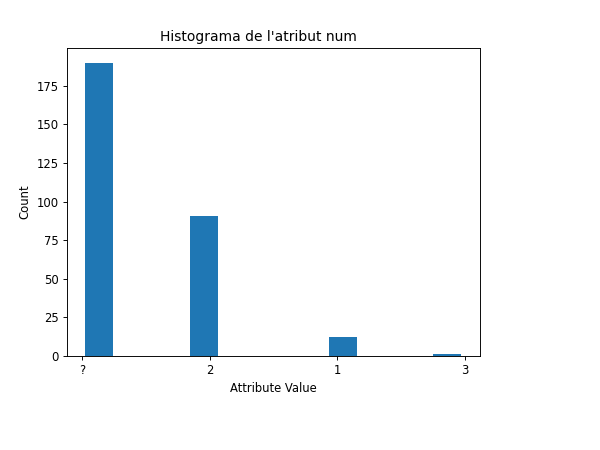

In [6]:
print("Per veure els histogrames de tots els atributs de la BBDD:")
index = 0
for col in dataset:
    if index < (data.shape[1]-1):
        plt.figure()
        plt.title(f"Histograma de l'atribut {col}")
        plt.xlabel("Attribute Value")
        plt.ylabel("Count")
        hist = plt.hist(x[:,index], bins=11, histtype="bar", rwidth=0.8)
        index+=1

També podem estudiar la correlació entre els diferents atributs per tal de saber si estan correlacionats entre ells.

<IPython.core.display.Javascript object>


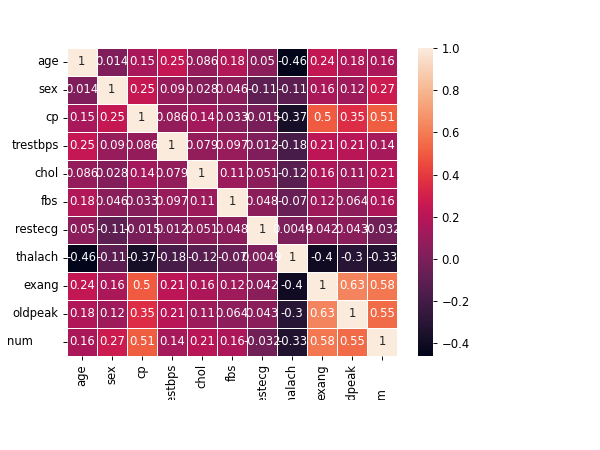

In [7]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)



També podem utilitzar la funció pairplot per tal de veure els atributs que estan relacionats entre si.

<IPython.core.display.Javascript object>


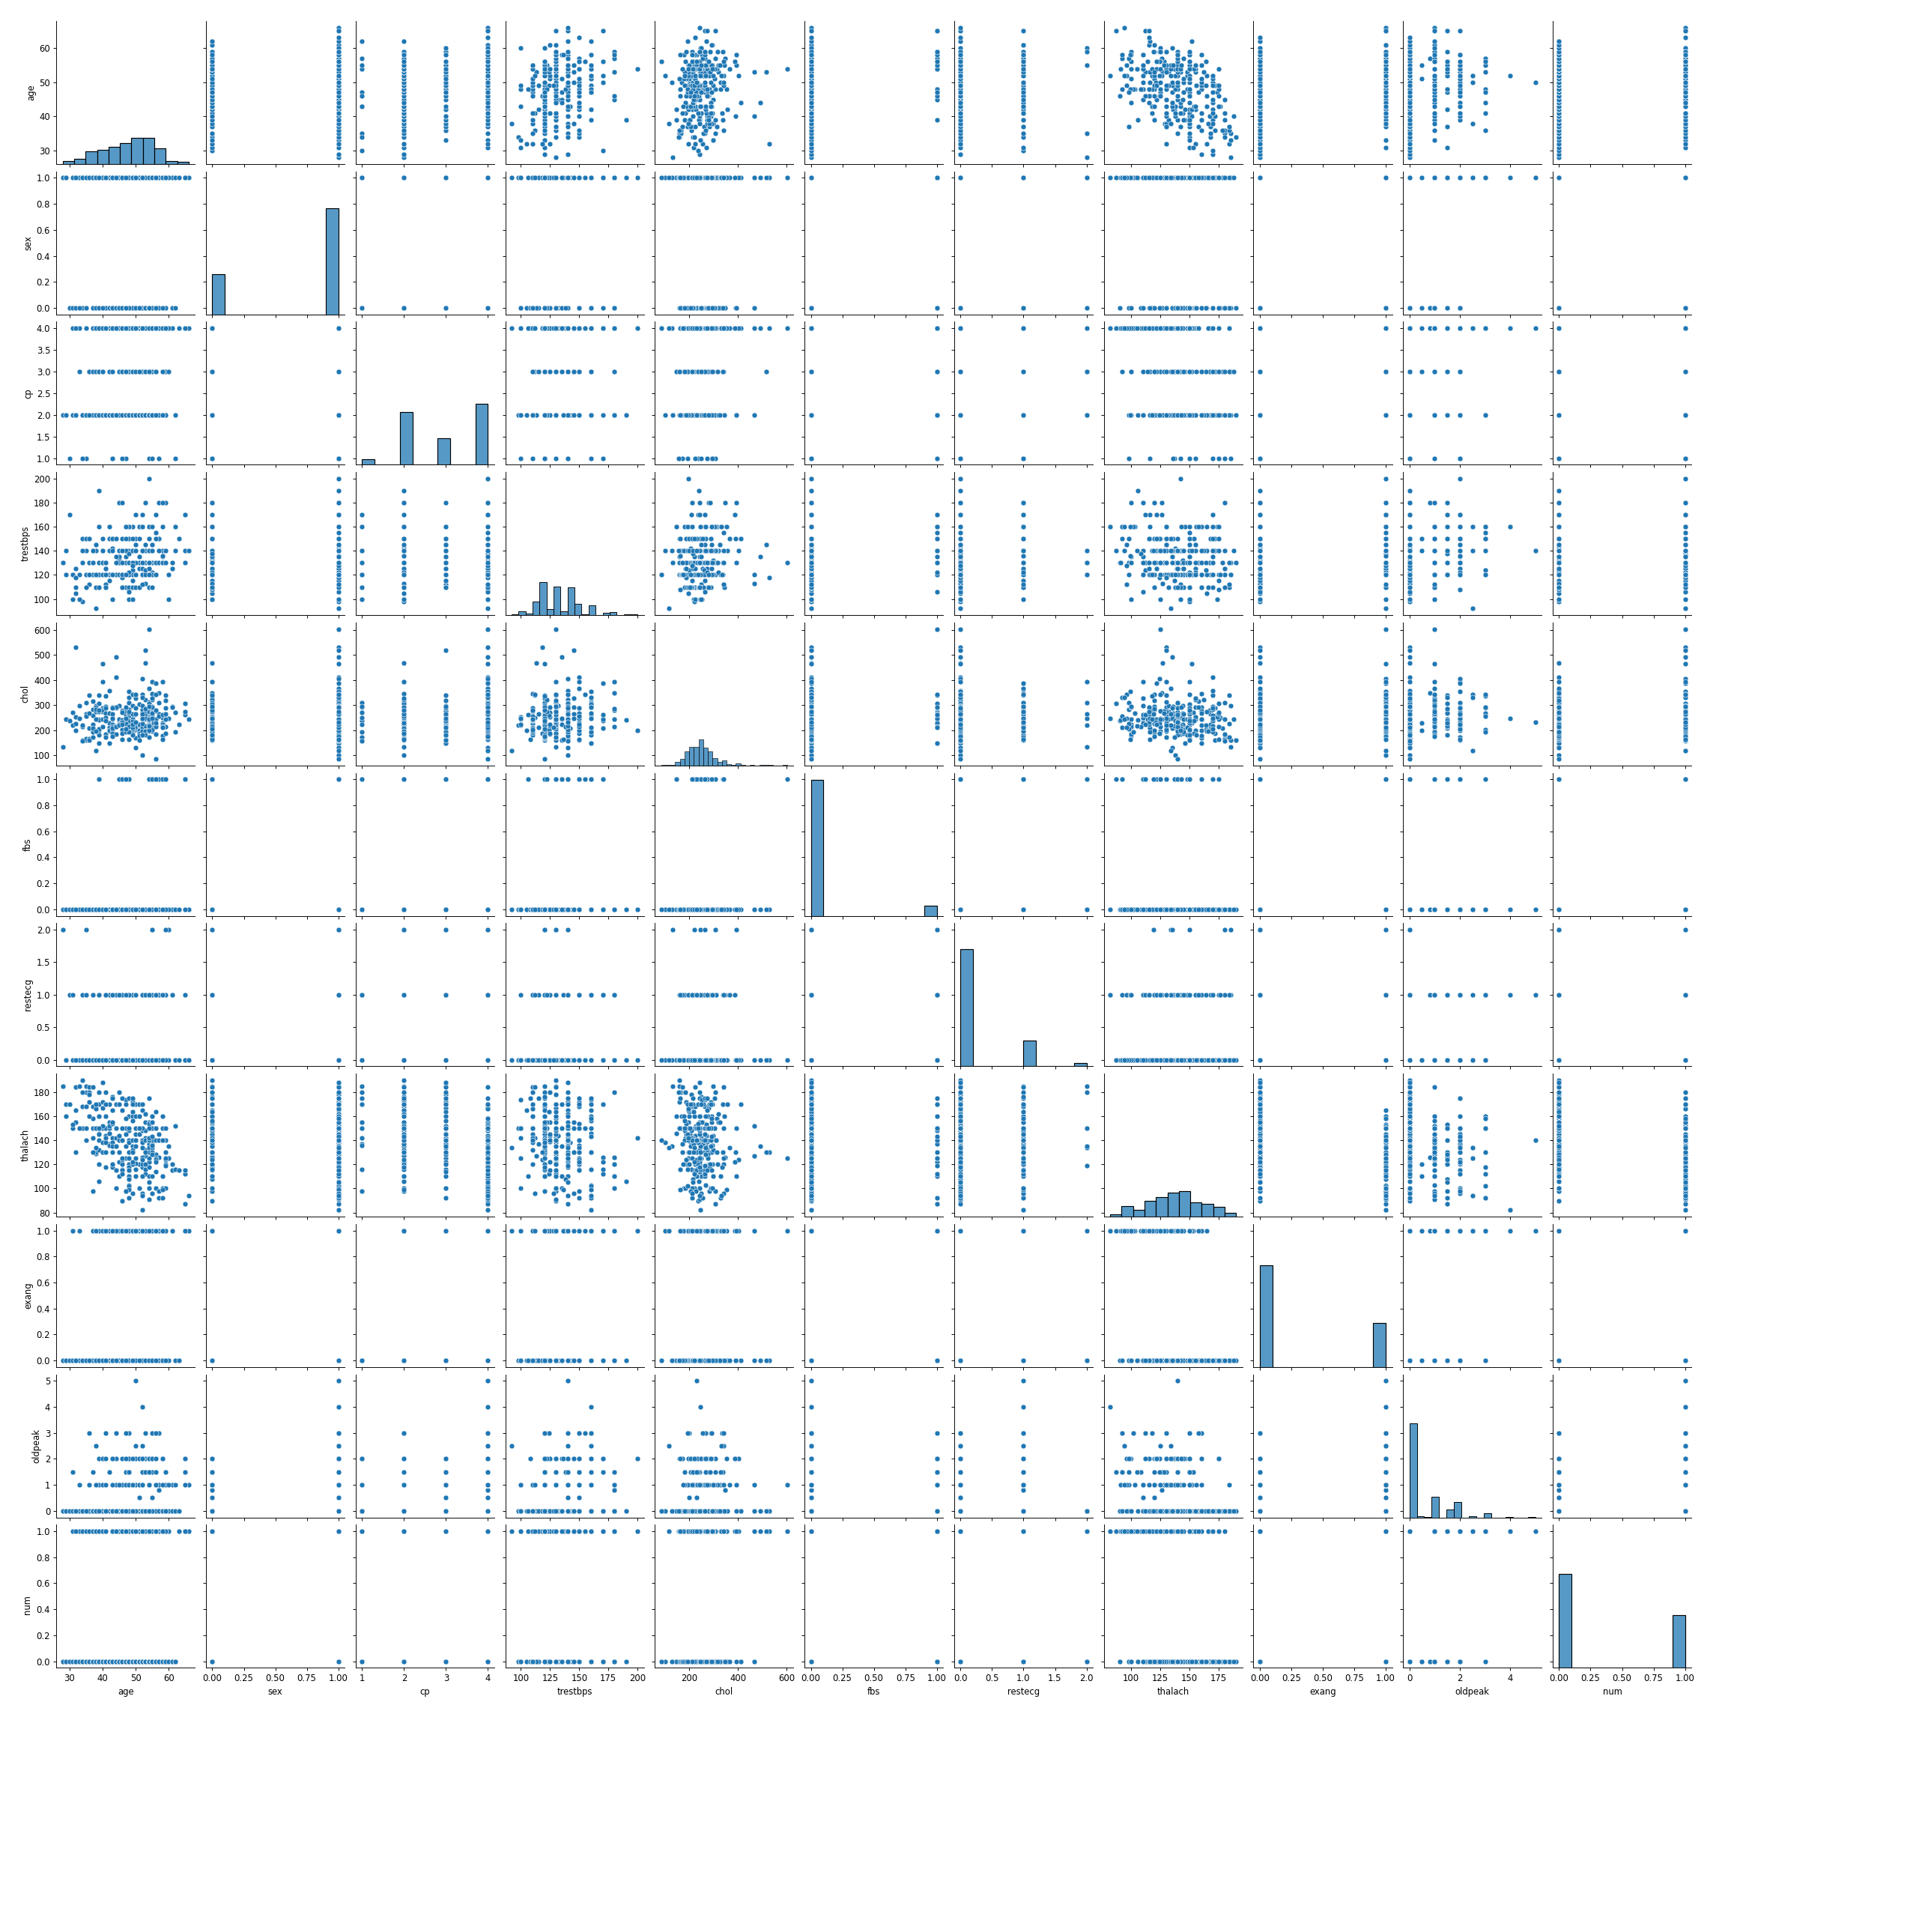

In [8]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset)

## Apartat (B): Primeres regressions

Per a aquest primer apartat es calcularà l'error quadràtic mitjà només del regressor per a cada un dels atributs de la base de dades, determinant aquell atribut pel qual l'error quadràtic mitjà (entre el valor predit i el real, per a cada mostra) és més baix. 

A continuació se us dona una funció auxiliar per a calcular l'error quadràtic mitjà:

In [9]:
import math

def mean_squared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

mean_squared_error([1,2,3,4], [1,2,1,4])

1.0

Per a agilitzar els càlculs es recomana utilitzar la llibreria numpy. Aquesta llibreria ens permet processar vectors sencers a la vegada de manera eficient i en paral·lel. Exemple:

In [10]:
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')

vector1 = np.array([1,2,3,4]) # convertim llista de python a numpy array
vector2 = np.array([1,2,1,4]) 

# podem sumar dos vectors element a element
print("Suma vector1 + vector2 ", vector1 + vector2)

# podem sumar tots els valors d'un vector
print("Suma valors vector1 ", vector1.sum())

# calculem la mitjana
print("Mitjana vector1", vector1.mean())

# utilitzem un vector com a índex de l'altre
# vector3 = vector1  # necesitem fer una copia del vector per no modificar el original
vector3 = vector1.copy()
vector3[vector2 == 1] = 5
print("Vector1 amb un 5 on el Vector2 te 1s ", vector3)

# es pot utilitzar numpy per a calcular el mse
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

print("MSE: ", mse(vector1, vector2))

Suma vector1 + vector2  [2 4 4 8]
Suma valors vector1  10
Mitjana vector1 2.5
Vector1 amb un 5 on el Vector2 te 1s  [5 2 5 4]
MSE:  1.0


Per a la regressió podeu utilitzar la llibreria sklearn:

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
l_column = list(dataset.columns) # Llista de les columnes
len_feature = len(l_column) # longitud columnes


X = dataset[l_column[0:len_feature-1]] #Atributs generals
y = dataset[l_column[len_feature-1]] #Atribut a predir

In [13]:
print("Feature set size:",X.shape)
print("Variable set size:",y.shape)

Feature set size: (294, 10)
Variable set size: (294,)


In [14]:
print("Atributos a estudiar")
X.head()

Atributos a estudiar


age   sex    cp  trestbps    chol   fbs  restecg  thalach  exang  oldpeak
0 28.000 1.000 2.000   130.000 132.000 0.000    2.000  185.000  0.000    0.000
1 29.000 1.000 2.000   120.000 243.000 0.000    0.000  160.000  0.000    0.000
2 29.000 1.000 2.000   140.000 243.000 0.000    0.000  170.000  0.000    0.000
3 30.000 0.000 1.000   170.000 237.000 0.000    1.000  170.000  0.000    0.000
4 31.000 0.000 2.000   100.000 219.000 0.000    1.000  150.000  0.000    0.000

In [15]:
print("Atributo objetivo")
y.head()

Atributo objetivo


0   0.000
1   0.000
2   0.000
3   0.000
4   0.000
Name: num       , dtype: float64

A continuació, es modificaran tots els atributs mitjançant **procediments de normalització (normal, estàndard)**, i s'avaluarà el rendiment del regressor après. Per a això, caldrà analitzar la mitja i variança de cada variable per totes les mostres, per identificar aquells valors que tenen una distribució normal, els preferits per fer regressió, i descartar altres atributs que no són representatius per fer la regressió, i que afegeixen soroll al model. 

Pel que fa a l'error resultant de la regressió, recordeu que es calcula fent la diferència entre el valor predit i el real al quadrat: així doncs, si les dades tenen valors grans (tipus 10^3), l'error al quadrat podria acabar sent 10^6. Per això és important normalitzar abans (escalar les dades a un rang més petit).

<img src="images/standarization.png">

Podeu estandarditzar les dades amb les funcions mean i std de numpy i mostrar l'hisotgrama de nou. Recuperant l'exemple de l'apartat anterior:

In [16]:
def standarize(x, mean=None, std=None):
    if mean is None:
        mean = x.mean(0)
    if std is None:
        std = x.std(0)
    
    return (x - mean[None, :]) / std[None, :], mean, std

In [17]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

Primero tenemos que hacer la división de las muestras de test y de entrenamiento

**Importamos train_test_split y r2_score de scikit-learn**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

**Creamos la división entre X y y para test y entrenamiento**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [20]:
print("Training feature set size:",X_train.shape)
print("Test feature set size:",X_test.shape)
print("Training variable set size:",y_train.shape)
print("Test variable set size:",y_test.shape)

Training feature set size: (205, 10)
Test feature set size: (89, 10)
Training variable set size: (205,)
Test variable set size: (89,)


Aplicamos la normalización a nuestros conjuntos

In [21]:
train_df_x_norm, mean, std = standarize(X_train.values)
test_df_x_norm, _, _ = standarize(X_test.values, mean, std)

train_df_y_norm, mean, std = standarize(y_train.values[:, None])
test_df_y_norm, _, _ = standarize(y_test.values[:, None], mean, std)

Per veure els histogrames de tots els atributs normalitzats de la BBDD:


<IPython.core.display.Javascript object>


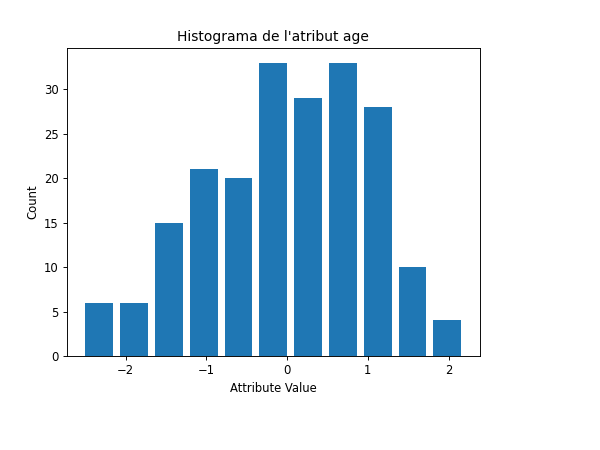

<IPython.core.display.Javascript object>


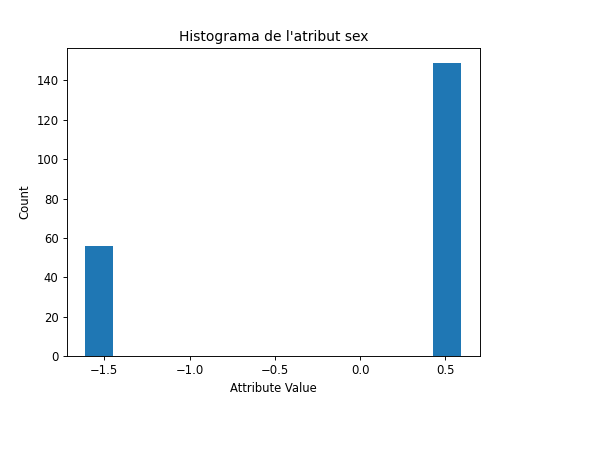

<IPython.core.display.Javascript object>


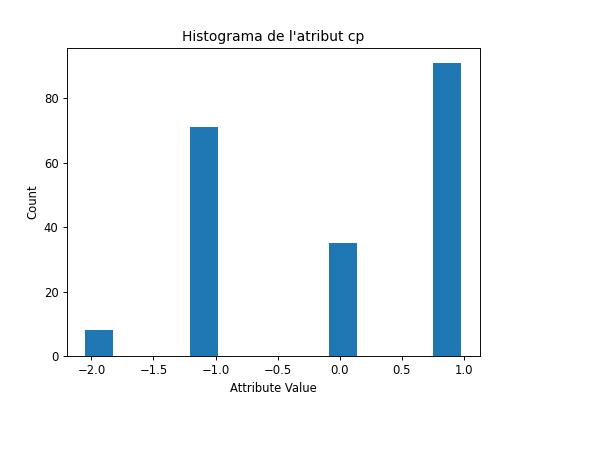

<IPython.core.display.Javascript object>


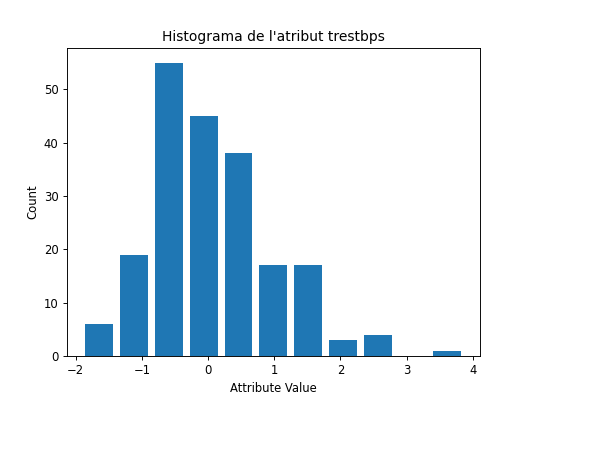

<IPython.core.display.Javascript object>


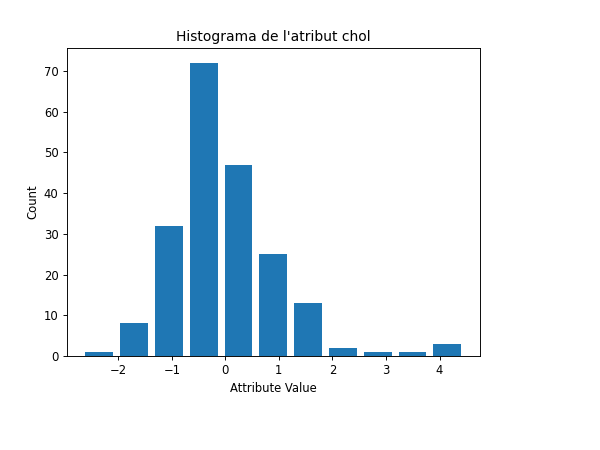

<IPython.core.display.Javascript object>


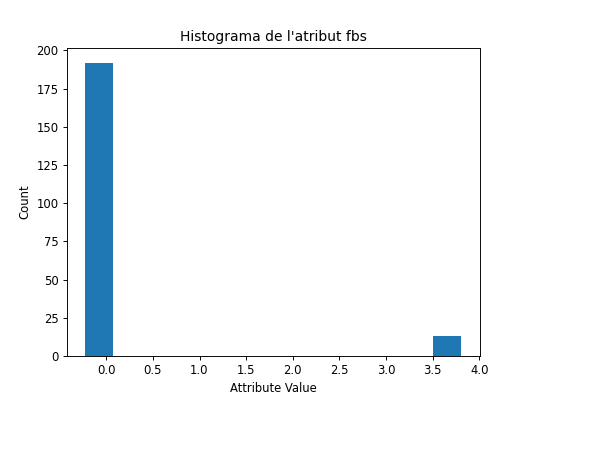

<IPython.core.display.Javascript object>


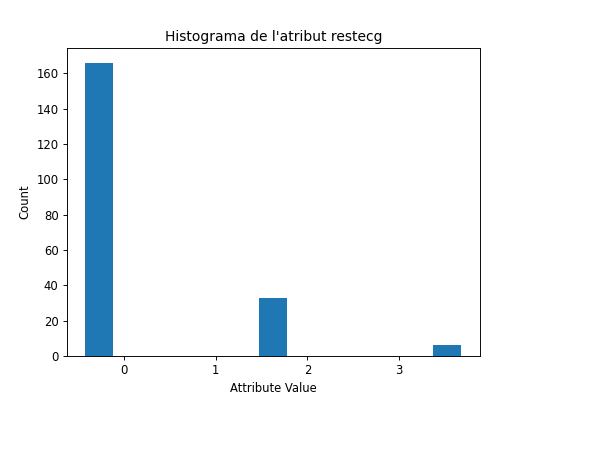

<IPython.core.display.Javascript object>


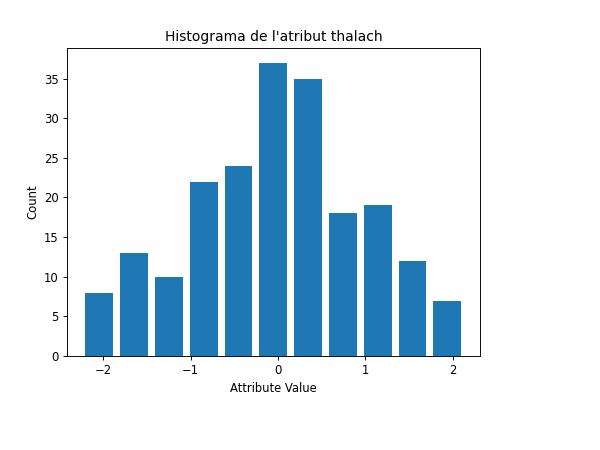

<IPython.core.display.Javascript object>


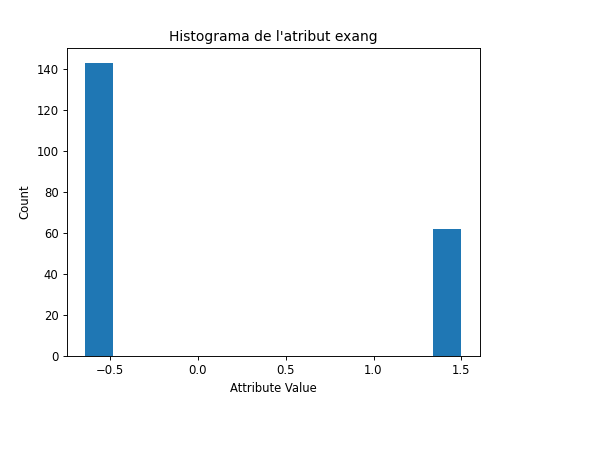

In [22]:
print("Per veure els histogrames de tots els atributs normalitzats de la BBDD:")
index = 0
for col in dataset:
    if index < 9:
        plt.figure()
        plt.title(f"Histograma de l'atribut {col}")
        plt.xlabel("Attribute Value")
        plt.ylabel("Count")
        hist = plt.hist(train_df_x_norm[:,index], bins=11, histtype="bar", rwidth=0.8)
        index+=1

Apliquem el nostre model de regressió lineal

In [23]:
linear_model = LinearRegression()    

features = X_train.columns
train_y = train_df_y_norm
test_y = test_df_y_norm

mses, r2s = [], []
features = features.tolist()

mses, r2s = [], []
for idx, feature in enumerate(features):
    linear_model.fit(train_df_x_norm[:, idx, None], train_df_y_norm)
    preds = linear_model.predict(test_df_x_norm[:, idx, None])
       
    mse = mean_squared_error(test_df_y_norm, preds)
    mses.append(mse)
    
    r2 = r2_score(test_y, preds)
    r2s.append(r2)
    print(f'Feature: {feature}; MSE: {mse}; R2: {r2};')


Feature: age; MSE: [1.02049161]; R2: 0.015027148133462731;
Feature: sex; MSE: [1.02333588]; R2: 0.01228187518214996;
Feature: cp; MSE: [0.84077562]; R2: 0.1884880285016849;
Feature: trestbps; MSE: [1.00810041]; R2: 0.026987062926830063;
Feature: chol; MSE: [1.03173007]; R2: 0.0041798522137418415;
Feature: fbs; MSE: [0.99974806]; R2: 0.035048711971788715;
Feature: restecg; MSE: [1.038292]; R2: -0.00215368776828484;
Feature: thalach; MSE: [0.89583198]; R2: 0.13534793547770263;
Feature: exang; MSE: [0.68230259]; R2: 0.34144531530175704;
Feature: oldpeak; MSE: [0.79745001]; R2: 0.23030566954778275;


Visualització MSE y R2 Score per cada atribut


<IPython.core.display.Javascript object>


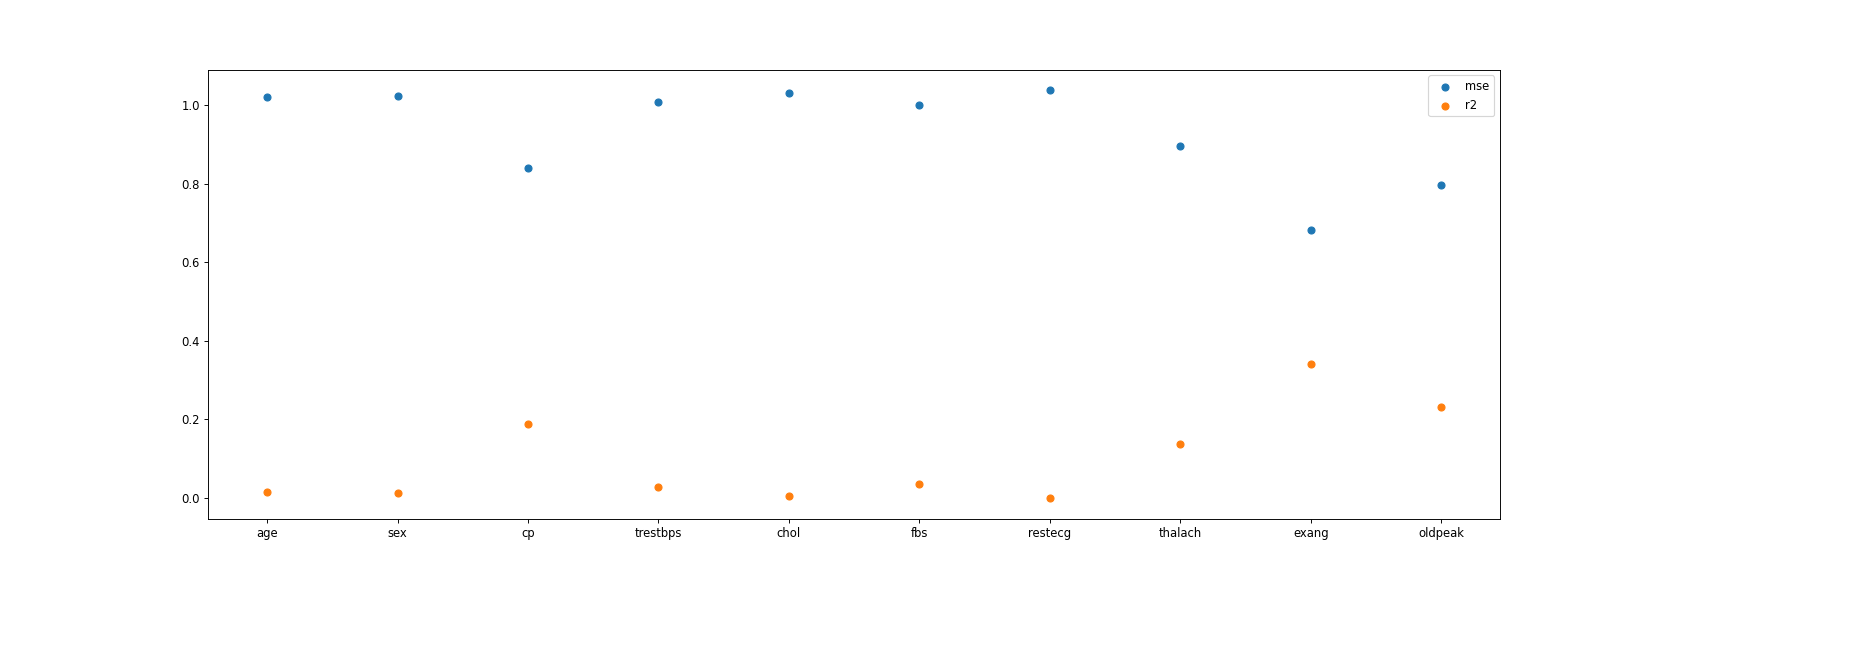

In [24]:
print("Visualització MSE y R2 Score per cada atribut")
mses = np.array(mses)
r2s = np.array(r2s)
plt.figure(figsize=(20,7)) 
plt.scatter(features, mses, label='mse')
plt.scatter(features, r2s, label='r2')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


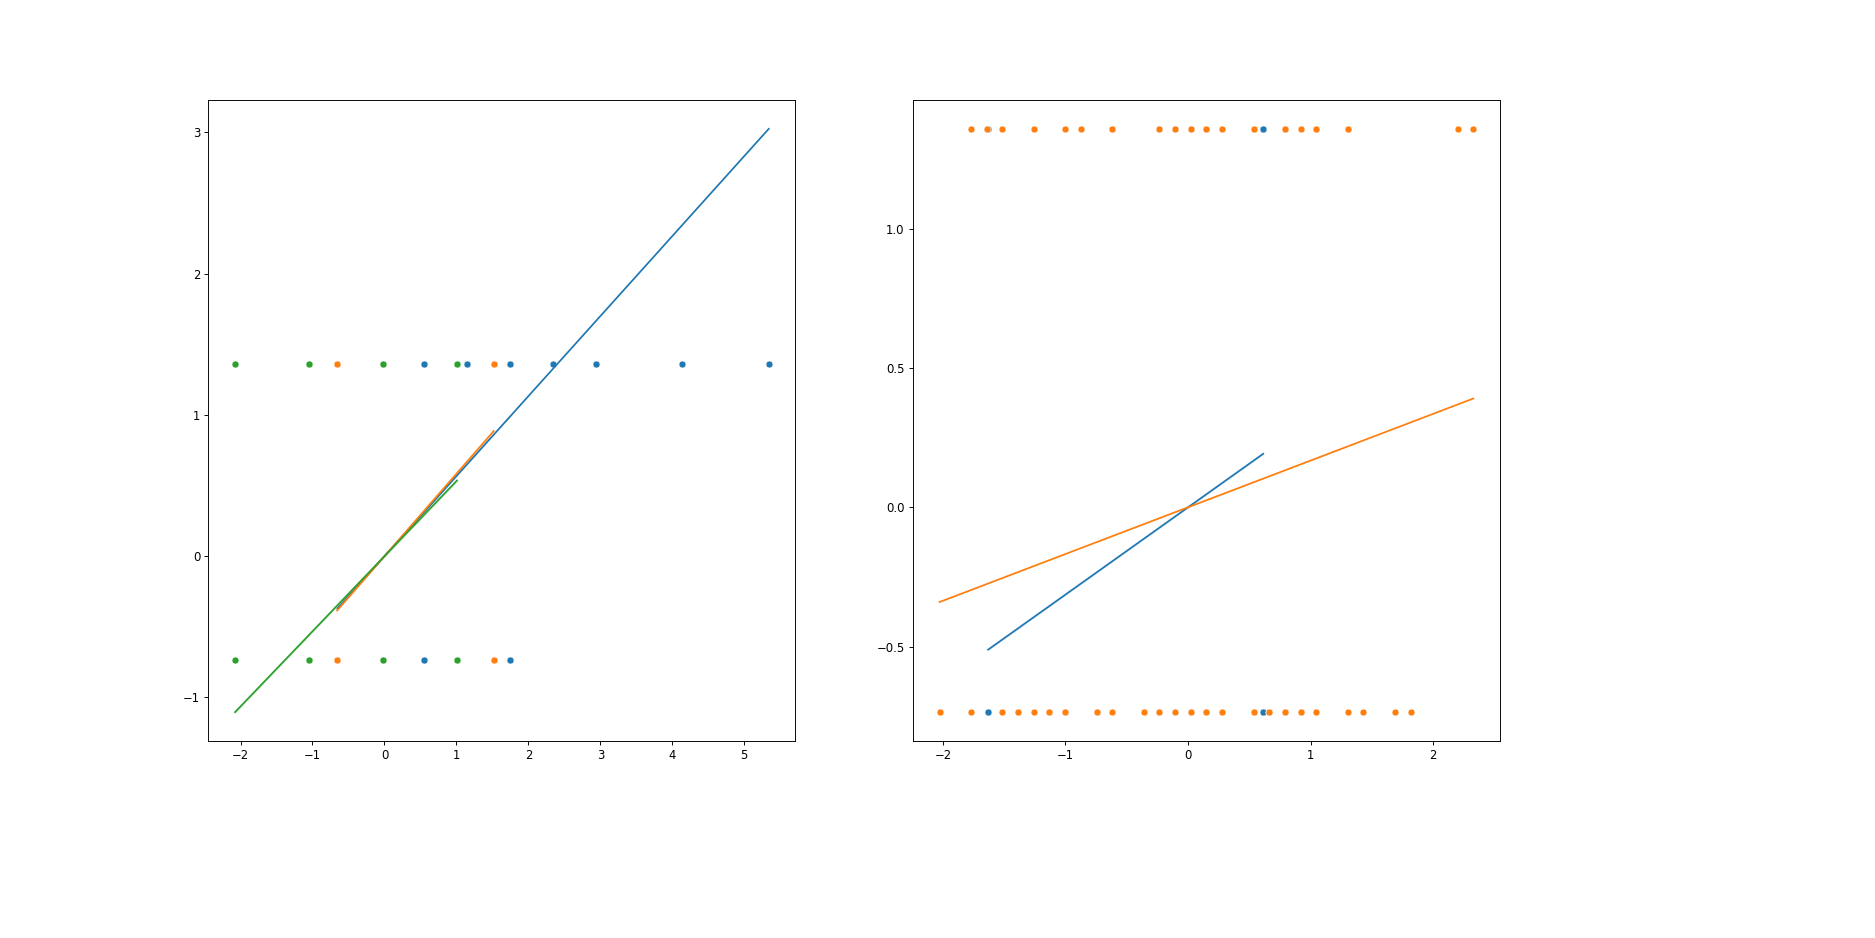

<AxesSubplot:>

In [25]:
#Fem la regressio de cada atribut amb la y

f, ax = plt.subplots(1, 2, figsize=(20,10))
age = linear_model.fit(train_df_x_norm[:, 0, None], train_df_y_norm)
preds_age = age.predict(test_df_x_norm[:, 0, None])
sex = linear_model.fit(train_df_x_norm[:, 1, None], train_df_y_norm)
preds_sex = sex.predict(test_df_x_norm[:, 1, None])
cp = linear_model.fit(train_df_x_norm[:, 2, None], train_df_y_norm)
preds_cp = cp.predict(test_df_x_norm[:, 2, None])
trestbps = linear_model.fit(train_df_x_norm[:, 3, None], train_df_y_norm)
preds_trestbps = trestbps.predict(test_df_x_norm[:, 3, None])
chol = linear_model.fit(train_df_x_norm[:, 4, None], train_df_y_norm)
preds_chol = chol.predict(test_df_x_norm[:, 4, None])
fbs = linear_model.fit(train_df_x_norm[:, 5, None], train_df_y_norm)
preds_fbs = fbs.predict(test_df_x_norm[:, 5, None])
restecg = linear_model.fit(train_df_x_norm[:, 6, None], train_df_y_norm)
preds_restecg = restecg.predict(test_df_x_norm[:, 6, None])
thalach = linear_model.fit(train_df_x_norm[:, 7, None], train_df_y_norm)
preds_thalach = thalach.predict(test_df_x_norm[:, 7, None])
exang = linear_model.fit(train_df_x_norm[:, 8, None], train_df_y_norm)
preds_exang = exang.predict(test_df_x_norm[:, 8, None])
oldpeak = linear_model.fit(train_df_x_norm[:, 9, None], train_df_y_norm)
preds_oldpeak = oldpeak.predict(test_df_x_norm[:, 9, None])

#Mostrem la regressio dels valors que volem veure
sns.lineplot(y=preds_oldpeak[:,0], x=test_df_x_norm[:, 9], ax=ax[0])
sns.scatterplot(y=test_df_y_norm[:,0], x=test_df_x_norm[:, 9], ax=ax[0])

sns.lineplot(y=preds_exang[:,0], x=test_df_x_norm[:, 8], ax=ax[0])
sns.scatterplot(y=test_df_y_norm[:,0], x=test_df_x_norm[:, 8], ax=ax[0])

sns.lineplot(y=preds_cp[:,0], x=test_df_x_norm[:, 2], ax=ax[0])
sns.scatterplot(y=test_df_y_norm[:,0], x=test_df_x_norm[:, 2], ax=ax[0])


sns.lineplot(y=preds_sex[:,0], x=test_df_x_norm[:, 1], ax=ax[1])
sns.scatterplot(y=test_df_y_norm[:,0], x=test_df_x_norm[:, 1], ax=ax[1])
sns.lineplot(y=preds_age[:,0], x=test_df_x_norm[:, 0], ax=ax[1])
sns.scatterplot(y=test_df_y_norm[:,0], x=test_df_x_norm[:, 0], ax=ax[1])


In [26]:
from sklearn.decomposition import PCA

In [27]:
#Fem la PCA

mses, r2s = [], []
for i in range(1, 9):
    pca = PCA(n_components=i)
    x_train = pca.fit_transform(train_df_x_norm)
    x_test = pca.transform(test_df_x_norm)

    linear_model = LinearRegression()
    linear_model.fit(x_train, train_df_y_norm)
    preds = linear_model.predict(x_test)

    mse = mean_squared_error(test_df_y_norm, preds)
    r2 = r2_score(test_df_y_norm, preds)
    #print(f"PCA_{i} - MSE: {mse:.3f}; R2: {r2:.3f}")
    print("PCA: ", i, "MSE: ", mse, "R2: ", r2)
    
    mses.append(mse)
    r2s.append(r2)
    
#plt.plot(mses, label='mse')
#plt.plot(r2s, label='r2')
#plt.legend()
#plt.show()


PCA:  1 MSE:  [0.62091823] R2:  0.400693157685832
PCA:  2 MSE:  [0.6138686] R2:  0.40749743053835386
PCA:  3 MSE:  [0.61461733] R2:  0.40677475925004436
PCA:  4 MSE:  [0.61424034] R2:  0.4071386286169225
PCA:  5 MSE:  [0.58319555] R2:  0.4371028860233833
PCA:  6 MSE:  [0.59805374] R2:  0.422761844060459
PCA:  7 MSE:  [0.59900744] R2:  0.4218413341581029
PCA:  8 MSE:  [0.59992956] R2:  0.42095130793276103


# Apartat (A): El descens del gradient  

En aquest exercici, es tracta d'implementar en python el procés de descent del gradient explicat a les classes de teoria, i comparar-lo amb els resultats obtinguts amb l'apartat (B). 

$$J(w) = \frac{1}{2m} \left[ \sum^m_{i=1}(f(x^{i}; w) - y^{i})^2 + \lambda\sum_{j=1}^{n}(w_{j}^2) \right]$$

Fixeu-vos que $J$ retorna el `mse`. Per a trobar $w_j$, repetir fins convergència:
$$w_0 = w_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot 1$$
$$w_j = w_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i} - \frac{\lambda}{m}w_{j} \right]$$


ó:

$$w_{j} := w_{j} \left(1-\alpha \frac{\lambda}{m} \right) - \alpha\frac{\lambda}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i}$$

On si considerem un regressor lineal (el model és una recta), llavors $w_0$ i $w_1$ representen, respectivament, la $b$ i $a$ de la fòrmula de la recta: 

$$h_\theta(x^{(i)}) = ax + b$$

$\alpha$ és el learning rate, i $h_\theta(x^{(i)})$ és la funció que fa la regressió, és a dir, la funció que prediu el valor de $y^{(i)}$ donat un(s) atribut(s) concret(s) $x^{(i)}$.

Així, tenint calculat el model en l'últim punt del primer exercici, ja sabeu quin resultat hauríeu d'obtenir. O no, perquè la vostra implementació pot ser millor! En concret, es tracta de desenvolupar aquestes tasques:

* Definir la funció de cost i del gradient

* Estudiar com l'ús de regularitzadors afecta el resultat: overfitting, underfitting, etc. 

* Visualització de les dades a analitzar i explicació pas a pas del procediment   

* Visualització del procés de descens de gradient 

* Modificar el learning rate i el nombre d'iteracions 

<img src="images/gradient_descent.png">

Per a la implementació us podeu basar en el següent esquelet:
    

<IPython.core.display.Javascript object>


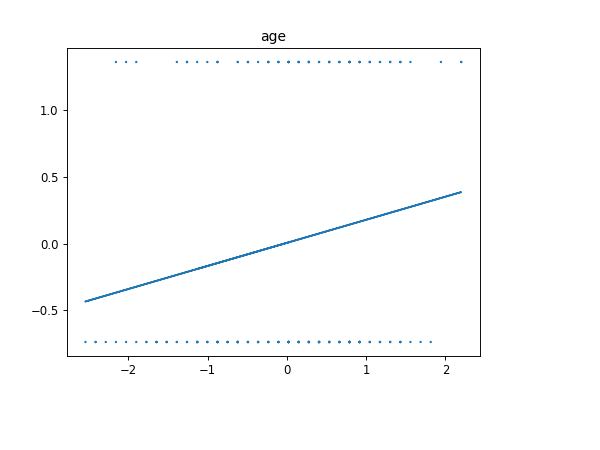

<IPython.core.display.Javascript object>


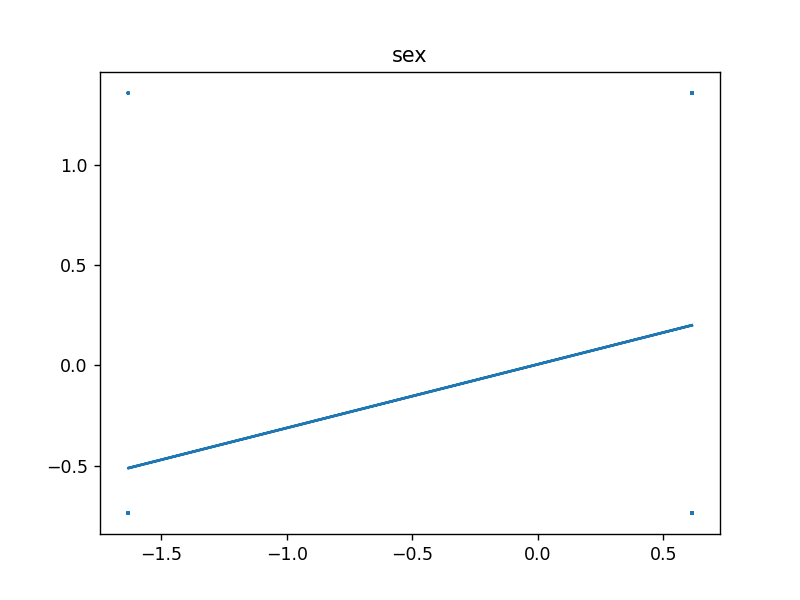

<IPython.core.display.Javascript object>


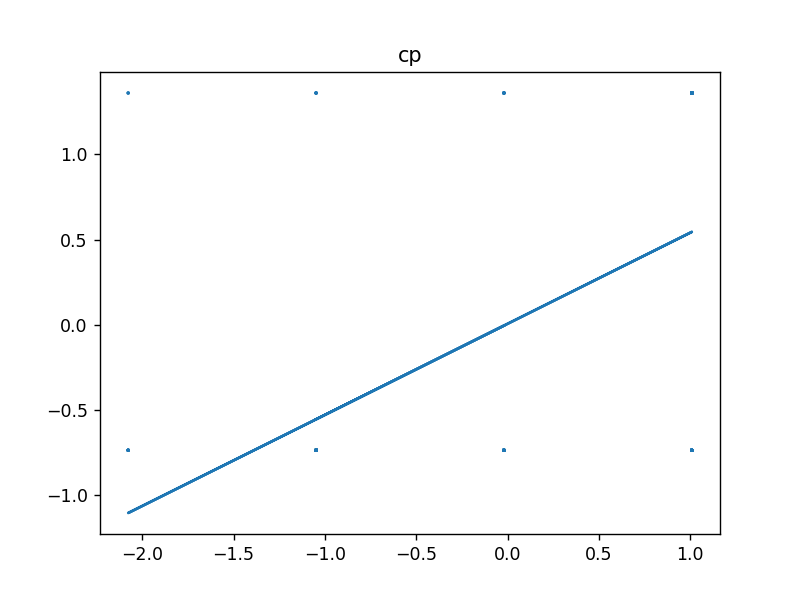

<IPython.core.display.Javascript object>


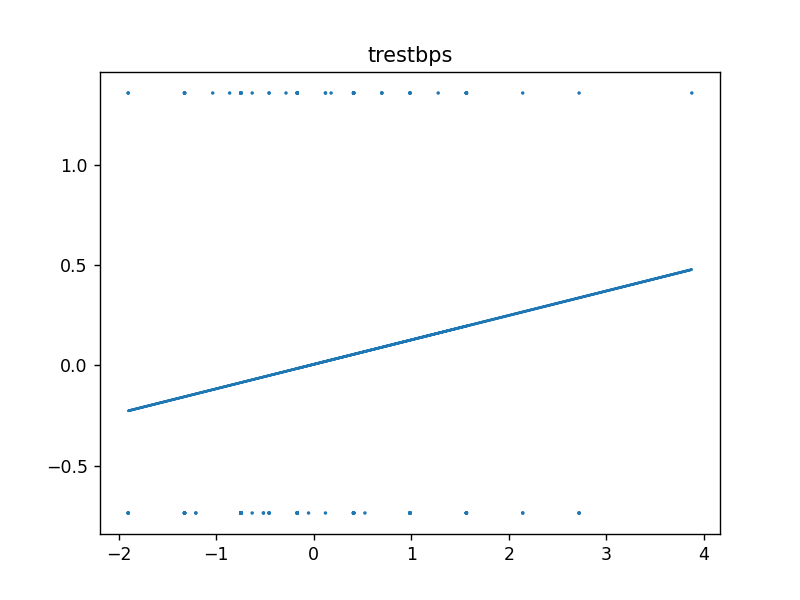

<IPython.core.display.Javascript object>


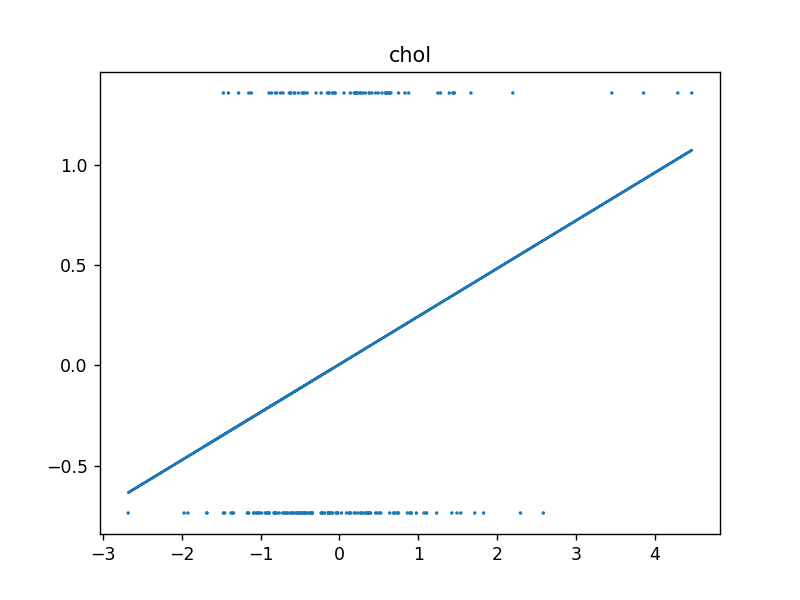

<IPython.core.display.Javascript object>


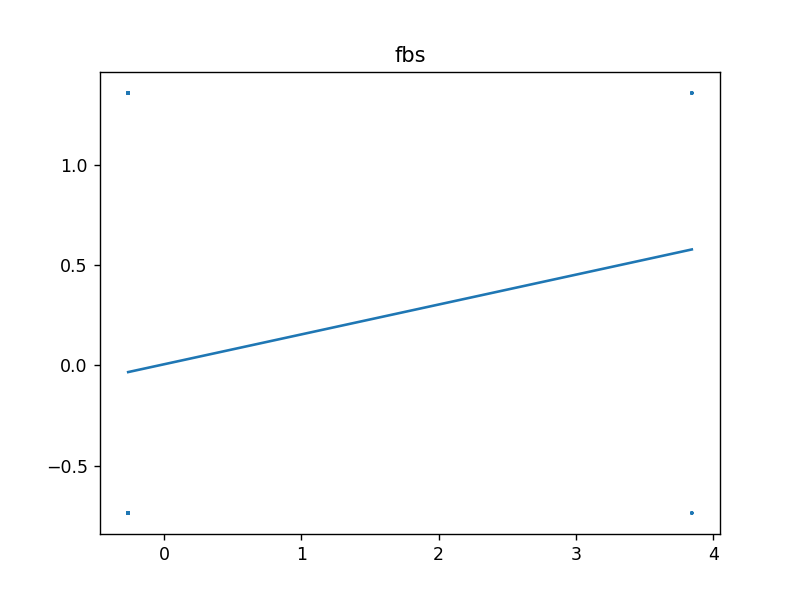

<IPython.core.display.Javascript object>


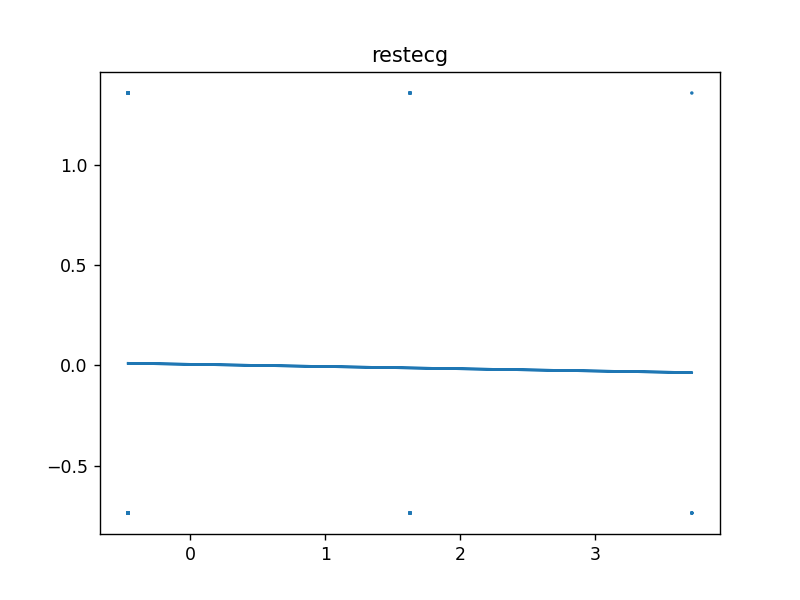

<IPython.core.display.Javascript object>


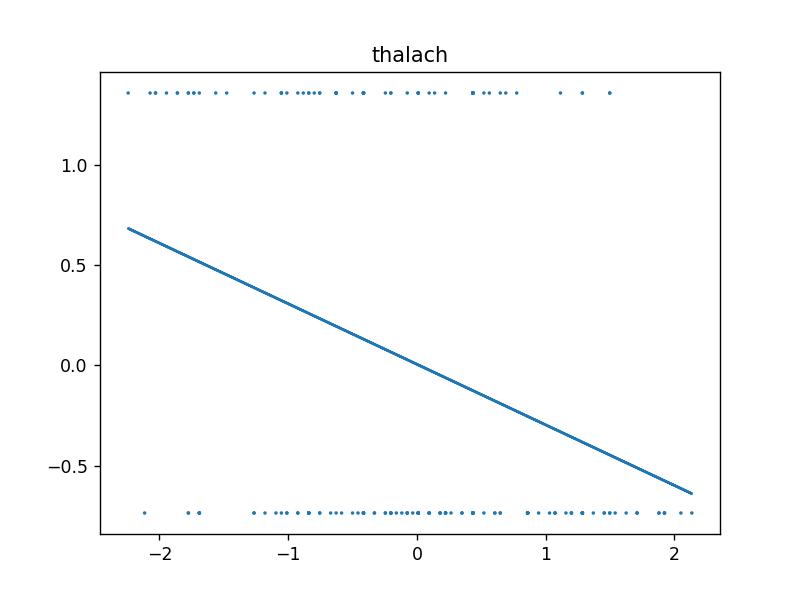

<IPython.core.display.Javascript object>


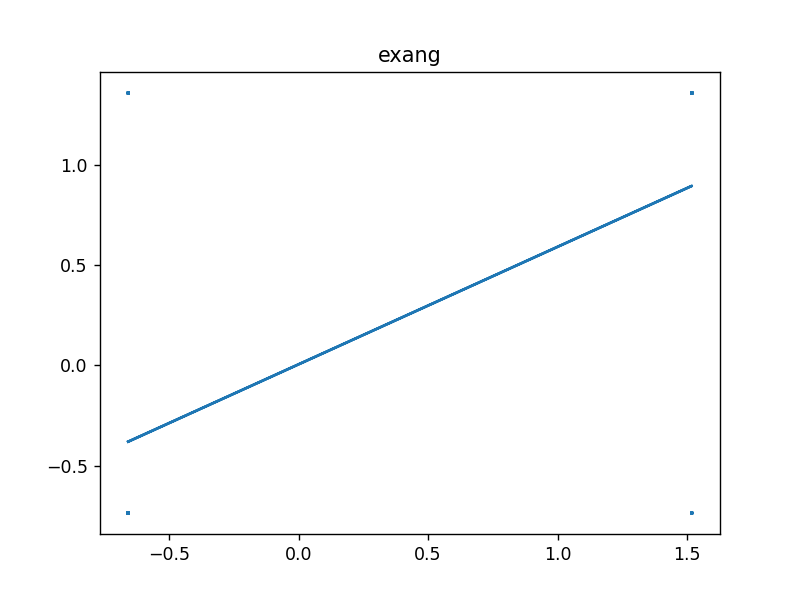

<IPython.core.display.Javascript object>


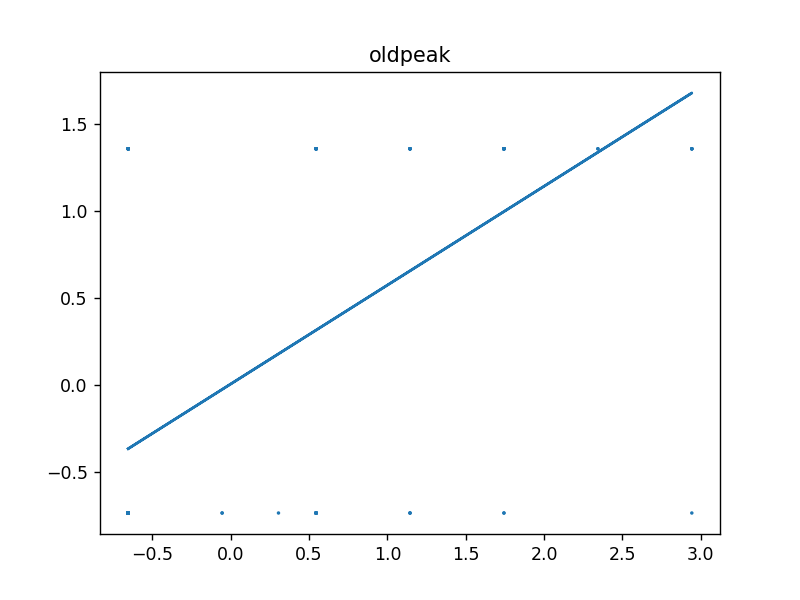

In [28]:
def cost(x, y, a, b):
    m = len(x)
    cost = 0.0
    for i in range(m):
        hist = a + b * x[i]
        cost += (y[i] - hist) ** 2
    return cost / (2 * m)

def descensgradiente(x, y, a, b, alpha, max_iter):

    hist = []
    for i in range(max_iter):
        der_a = 0
        der_b = 0
        for i in range(len(x)):
            aux = a + b * x[i]
            der_a += aux - y[i]
            der_b += (aux - y[i]) * x[i]
            hist.append(cost(x, y, a, b))
        a -= (der_a / len(x)) * alpha
        b -= (der_b / len(x)) * alpha

    return a, b, hist

for i in range(train_df_x_norm.shape[1]):
    x = train_df_x_norm[:, i]
    y = train_df_y_norm
    s = np.full((y.shape[0],y.shape[1]), 1)

    w0, w1, hist = descensgradiente(x,y,1,1,0.05,100)

    recta = w1*x + w0
    plt.figure()
    plt.title(label=dataset.columns[i])
    plt.scatter(x,y,s=s)
    plt.plot(x, recta)
